# SVI for Poisson RGG

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../utils')

In [3]:
from graphs import (get_independent_components_rgg, make_inter_vertex_distances, 
                    deg_corrected_poissonian_random_geometric_graph)

In [4]:
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time
import pandas as pd

In [5]:
SEED = 42
n = 10
dim = 2

In [6]:
lambda_r_truth = 2
exponential_kernel = lambda dist, ki, kj: ki * kj * math.exp(-lambda_r_truth * dist)

In [7]:
kolness_truth = np.ones(n)
kolness_truth[0] = 10

In [8]:
r = np.random.RandomState(SEED)
G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, kolness_truth, exponential_kernel, r, 
)

In [9]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

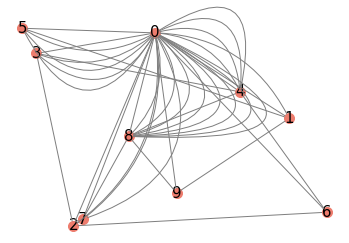

In [10]:
ax = plot_multigraph(G_poisson)

In [11]:
distances = make_inter_vertex_distances(G_poisson)

## Inference

In [12]:
import pyro.distributions as dist
import pyro
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch

In [13]:
distances = torch.tensor(distances)
distances

tensor([[0.0000, 0.5017, 0.8242, 0.3276, 0.3320, 0.3545, 0.8688, 0.7911, 0.4317,
         0.6620],
        [0.5017, 0.0000, 0.7264, 0.7251, 0.1706, 0.8025, 0.3992, 0.6893, 0.4341,
         0.4296],
        [0.8242, 0.7264, 0.0000, 0.7169, 0.7092, 0.8251, 0.6788, 0.0376, 0.3974,
         0.3073],
        [0.3276, 0.7251, 0.7169, 0.0000, 0.5656, 0.1103, 1.0135, 0.6939, 0.4209,
         0.6858],
        [0.3320, 0.1706, 0.7092, 0.5656, 0.0000, 0.6368, 0.5471, 0.6716, 0.3489,
         0.4499],
        [0.3545, 0.8025, 0.8251, 0.1103, 0.6368, 0.0000, 1.1104, 0.8029, 0.5278,
         0.7936],
        [0.8688, 0.3992, 0.6788, 1.0135, 0.5471, 1.1104, 0.0000, 0.6513, 0.6137,
         0.4082],
        [0.7911, 0.6893, 0.0376, 0.6939, 0.6716, 0.8029, 0.6513, 0.0000, 0.3626,
         0.2724],
        [0.4317, 0.4341, 0.3974, 0.4209, 0.3489, 0.5278, 0.6137, 0.3626, 0.0000,
         0.2662],
        [0.6620, 0.4296, 0.3073, 0.6858, 0.4499, 0.7936, 0.4082, 0.2724, 0.2662,
         0.0000]], dtype=tor

In [14]:
adj = torch.tensor(adj)
adj

tensor([[0, 2, 2, 3, 5, 4, 1, 3, 9, 1],
        [2, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [2, 0, 0, 1, 0, 0, 1, 2, 0, 0],
        [3, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [5, 0, 0, 1, 0, 0, 1, 0, 1, 0],
        [4, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 2, 0, 0, 0, 0, 0, 1, 0],
        [9, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0]])

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j \mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j \mathcal{F}(D_{ij}, \theta))$$

In [15]:
g = dist.Gamma(1,0.1)

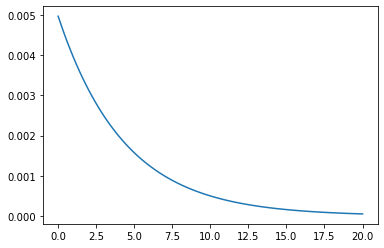

In [16]:
x = np.linspace(0.01,20,100)
plt.plot(x, 10**g.log_prob(x))

In [17]:
def dc_poisson_rgg_model(distances, adj):
    n_nodes = adj.shape[0]
    k = pyro.sample("k", dist.Gamma(1., 0.1).expand([n_nodes]).to_event(1))  # tell pyro that these are all dependent variables
    lambda_r = pyro.sample("lambda_r", dist.Gamma(1., 0.1))
    conn_kernel = torch.exp(-lambda_r*distances)
    
    assert k.shape == (n_nodes,)
    assert conn_kernel.shape == (n_nodes, n_nodes)
    
    r, c = torch.triu_indices(n_nodes, n_nodes)    
    
    for i in pyro.plate("data_loop", len(r)):
        conn_kernel_i = k[r[i]]*k[c[i]]*conn_kernel[r[i],c[i]]
        pyro.sample(f"obs_{i}", dist.Poisson(k[r[i]]*k[c[i]]*conn_kernel_i), obs=adj[r[i],c[i]]) 

def dc_poisson_rgg_guide(distances, adj):
    n_nodes = adj.shape[0]
    k = pyro.sample("k", dist.Gamma(1., 0.1).expand([n_nodes]).to_event(1))  # tell pyro that these are all dependent variables
    lambda_r = pyro.sample("lambda_r", dist.Gamma(1., 0.1))    

In [18]:
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)

In [19]:
adam = pyro.optim.Adam({'lr': 0.01})
svi = SVI(dc_poisson_rgg_model, dc_poisson_rgg_guide, adam, loss=Trace_ELBO())

In [20]:
r, _ = torch.triu_indices(adj.shape[0], adj.shape[0])
n_data = len(r)

In [21]:
n_steps = 1000
losses = []

pyro.clear_param_store()
for j in range(n_steps):
    loss = svi.step(distances, adj)
    losses.append(loss)
    if j % 100 == 0:
        print(f"[iteration{j+1: 04d}] loss: {loss/n_data:.4f}")

[iteration 001] loss: 12625.8526
[iteration 101] loss: 727.6529
[iteration 201] loss: 98104.2865
[iteration 301] loss: 3470.8251
[iteration 401] loss: 12889.3459
[iteration 501] loss: 4023.2424
[iteration 601] loss: 11030.4013
[iteration 701] loss: 9999.7206
[iteration 801] loss: 14220.7811
[iteration 901] loss: 46263.1676


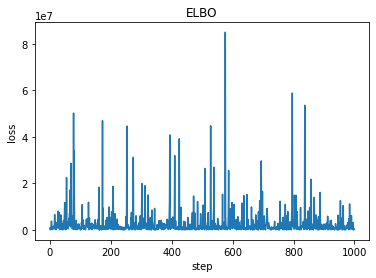

In [22]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");

## Exact inference

In [23]:
import arviz as az

In [24]:
from pyro.infer import MCMC, NUTS

In [25]:
nuts_kernel = NUTS(dc_poisson_rgg_model)

In [ ]:
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(distances, adj)

Sample:  79%|▊| 1587/2000 [04:05,  8.35it/s, step size=4.82e-01, acc. prob=0.873]

In [ ]:
inferred = az.from_pyro(mcmc)

In [ ]:
summary = az.summary(inferred) # , var_names = ['lambda_r', 'kolness']
summary

In [ ]:
az.plot_trace(inferred, var_names = ['k', 'lambda_r']);

In [ ]:
lambda_r_truth

In [ ]:
az.plot_posterior(inferred, var_names = ['lambda_r', 'k'], ref_val = [lambda_r_truth] + list(kolness_truth));

In [ ]:
az.to_netcdf(inferred, 'pyro-poisson-rgg.netcdf')

In [ ]:
inferred = az.from_netcdf('pyro-poisson-rgg.netcdf')

## MAP estimation